<a href="https://colab.research.google.com/github/YogithL/Data-Science/blob/main/Unit5ExercisesSF_YogithL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [2]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [3]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [4]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

<Axes: xlabel='FT%', ylabel='FG%'>

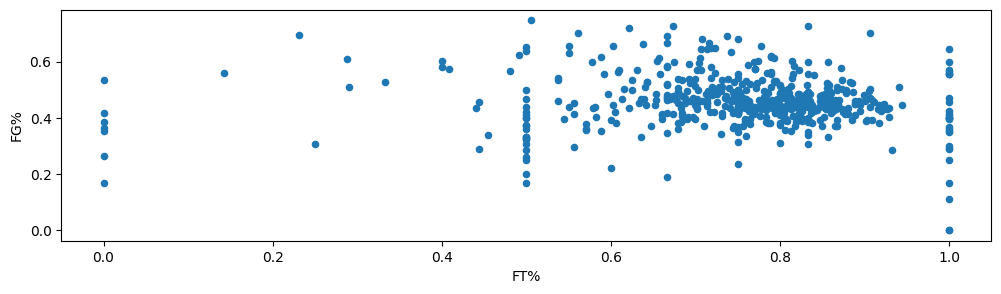

In [5]:
basketball.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")


At a glance, the graph doesn't exhibit any linear pattern, however, there are a few things to note. First off, a signficant portion of the data is clustered around suspiciously "perfect values" like 0, .5, and 1. This could stem from the fact that these players have only played a limited number of games; for instance, those with a perfect FT% of 1 may have only had one free throw until then (which they then made). Second, most of the data points fall within a range of .6 - .8 FT% and .3 - .5 FG%. In context, this makes sense because players who consistently score field goals are also likely to make free throws because they are made as close or closer to the basket.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

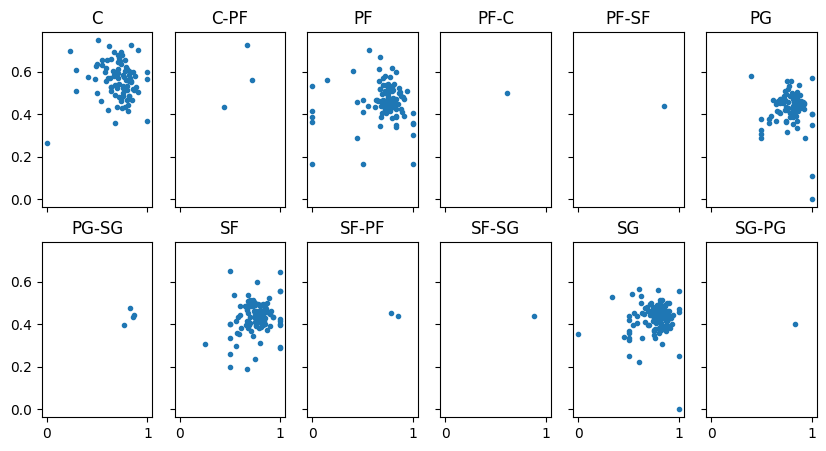

In [6]:
#this is an array of the basketball positions
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}


#set up the 12 plots
_ , ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

We concluded that the graphs created from the notes had 2 negative correlations, while the others showed zero correlation or lacked enough data to make a prediction. In this case, C (center) and SF (small forward) have negative and positive correlations respectively, while the remaining positions have zero correlation or insufficient data to make a prediction. With this in mind, I think the reason the linear regression from the notes worked is because the computer could infer the overall correlation was negative. However, in this case, we have two sets of graphs that have an interpretable corrlations that are conflicting. Due to this, our computer is unable to reconcile these patterns and is lost.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [7]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [8]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

<Axes: xlabel='height', ylabel='weight'>

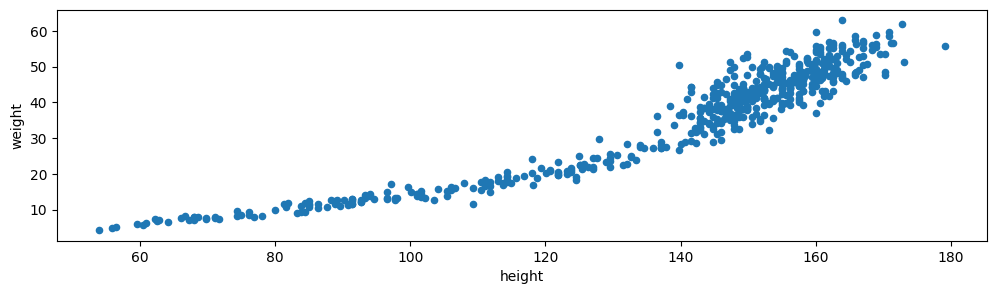

In [9]:
howell.plot(x="height", y="weight", figsize=(12, 3), kind="scatter")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [10]:
with pm.Model() as model_1:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for the standard deviation of our likelihood
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_h = pm.sample()


Output()

Output()

Text(0, 0.5, 'Wieght')

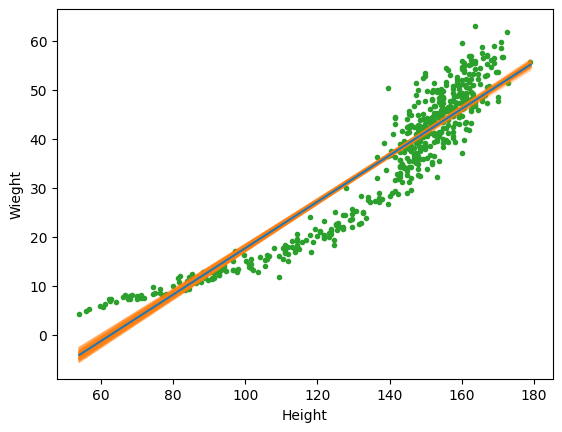

In [11]:
#grabs 100 posterior samples
posterior = az.extract(idata_h, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

# this creates the expected line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Height")
ax.set_ylabel("Wieght")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

Text(0, 0.5, 'weight')

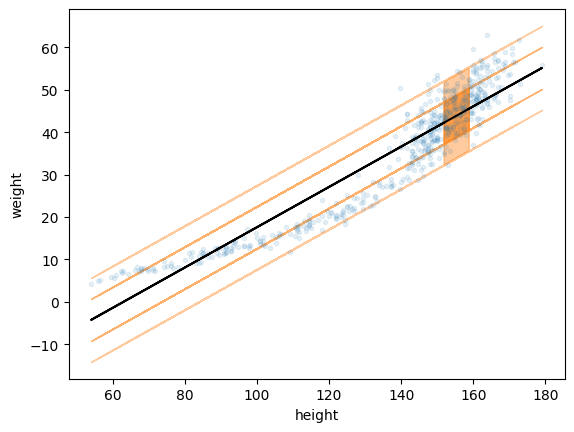

In [12]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_h1 = az.extract(idata_h)

μ_m = posterior_h1["μ"].mean("sample").values
σ_m = posterior_h1["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

Output()

<Axes: xlabel='y_pred'>

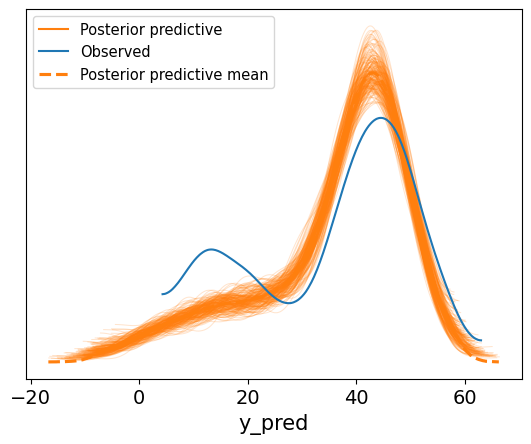

In [13]:

pm.sample_posterior_predictive(idata_h, model = model_1, extend_inferencedata=True)

az.plot_ppc(idata_h, num_pp_samples=200, colors=["C1", "C0", "C1"])


The model isn't pretty great, but it's not horrible. It's end behavior on the LHS is way off of the PPM and it overestimates those heights. Additionally, the model underestimates the values between 25-45, until it reaches after 45, where it finally converges to the PPM. The posterior line is a pretty decent considering the data is curved. Ultimately, I think this model is a very good starting place, but we can modify it to exhibit the data's curvature.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [19]:
with pm.Model() as model_2:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height))

    #prior for the standard deviation of our likelihood
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    y_pred = pm.Gamma("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_h2 = pm.sample()


Output()

Output()

Text(0, 0.5, 'Weight')

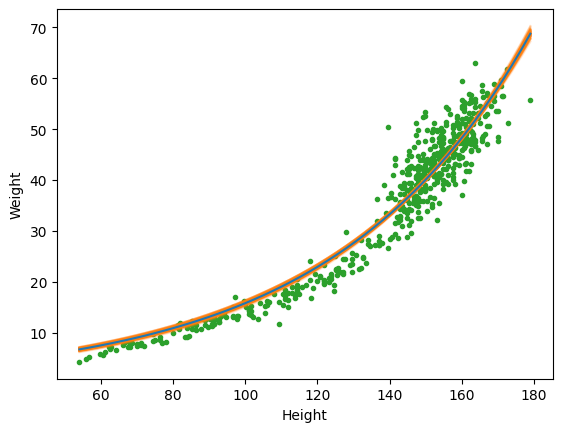

In [28]:
posterior = az.extract(idata_h2, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = np.exp(posterior["α"].mean() + posterior["β"].mean() * x_plot)

#These are a 50 lines that our model came up with
lines = np.exp(posterior["α"] + posterior["β"] * x_plot)

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Height")
ax.set_ylabel("Weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

Output()

Text(0, 0.5, 'Weight')

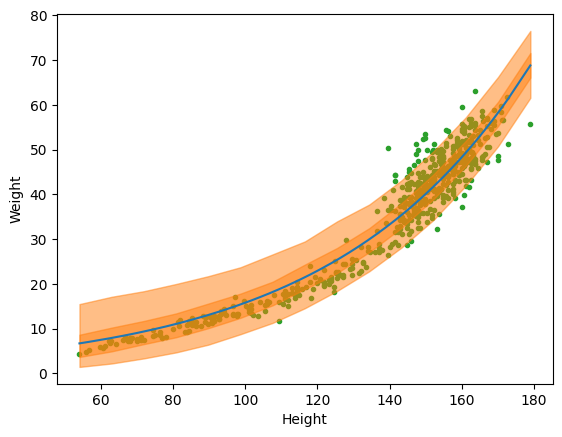

In [21]:
pm.sample_posterior_predictive(idata_h2, model = model_2, extend_inferencedata=True)

mean_line = idata_h2.posterior["μ"].mean(("chain", "draw"))
height = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(height)
x = np.linspace(height.min(), height.max(), 15)
y_pred_q = idata_h2.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(height[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("Height")
ax.set_ylabel("Weight")

<Axes: xlabel='y_pred'>

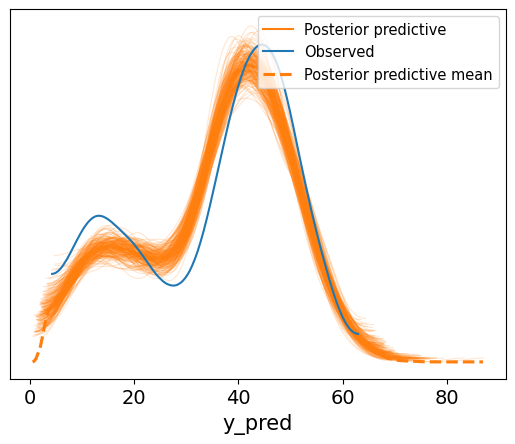

In [24]:
az.plot_ppc(idata_h2, num_pp_samples=200, colors=["C1", "C0", "C1"])

So, this new model was a success, but it does have a few issues! From looking at the posterior predictive distribution, we still have some of the issues from last time, particularly the hump on the left-hand side. Additionally, the graph still underestimates values between 25 and 40, but at  a lower magnitude. On a positive note, the distribution better fits the RH end behavior of the graph compared to last time. Ultimately, I think using a linear generalization to account for the curvature led to a better model overall.